## Example 14 - Emission footprint of IWT

#### Create an environment named: "gdal"

Install Anaconda3-2020.07-Windows-x86_64.exe

In the Anaconda prompt execute the following commands:

    conda create --name gdal
    conda activate gdal

    conda config --add channels conda-forge 
    conda config --set channel_priority strict

    conda install gdal
    yes
    conda install geopandas
    yes
    conda install folium
    yes
    conda install pyyaml
    yes

    cd c:\Users\MRV\OneDrive - Van Oord\Software\github\OpenTNSim\
    pip install -e .

    conda install jupyter
    yes

    cd ..
    jupyter notebook

https://nbviewer.jupyter.org/github/Deltares/digitaltwin-waterway/blob/master/notebooks/scenario-discharge.ipynb

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {} - branch: Afstuderen_LoesSegers'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.0.0 - branch: Afstuderen_LoesSegers


In [2]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os
import pathlib
import io
import urllib
import tempfile
import functools
import logging
import pickle

# package(s) related to the simulation
import simpy
import networkx as nx  

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
from osgeo import ogr, osr
from simplekml import Kml, Style
import folium

# package(s) for data handling
import requests
import math             
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

In [3]:
# Link to the latest version of the 'Vaarweginformatie.nl' network
url = 'https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml'

In [4]:
# Link to vessel database
location_vessel_database = "Vessels\Vessel-database-2.csv"

## 0. Load useful methods

### A) Network functions

In [5]:
@functools.lru_cache
def load_fis_network(url):
    """load the topological fairway information system network (vaarweginformatie.nl)"""

    # get the data from the url
    resp = requests.get(url)
    # convert to file object
    stream = io.StringIO(resp.text)
    
    # This will take a minute or two
    # Here we convert the network to a networkx object
    G = nx.read_yaml(stream)

    # some brief info
    n_bytes = len(resp.content)
    msg = '''Loaded network from {url} file size {mb:.2f}MB. Network has {n_nodes} nodes and {n_edges} edges.'''
    summary = msg.format(url=url, mb=n_bytes / 1000**2, n_edges=len(G.edges), n_nodes=len(G.nodes))
    logger.info(summary)

    # The topological network contains information about the original geometry. 
    # Let's convert those into python shapely objects for easier use later
    for n in G.nodes:
        G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    for e in G.edges:
        edge = G.edges[e]
        edge['geometry'] = shapely.wkt.loads(edge['Wkt'])
        edge['length'] = edge_length(edge)    
    
    return G 

In [6]:
def find_closest_node(G, point):
    """find the closest node on the graph from a given point"""
    
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    
    return name_node, distance_node

In [7]:
def find_closest_edge(G, point):
    """find the closest edge on the graph from a given point"""
    
    distance = np.full((len(G.edges)), fill_value=np.nan)
    for ii, e in enumerate(G.edges):
        distance[ii] = point.distance(G.edges[e]['geometry'])
    name_edge = list(G.edges)[np.argmin(distance)]
    distance_edge = np.min(distance)
    
    return name_edge, distance_edge

In [8]:
def edge_length(edge):
    """compute the great circle length of an edge
    The network version 0.1 contains the lat/lon distance in a length property. 
    But we need the "great circle" or projected distance. 
    Let's define a function to recompute it.
    """
    
    # get the geometry
    geom = edge['geometry']
    # get lon, lat
    lats, lons = np.array(geom).T
    # this requires pyproj 2.3.0
    distance = geod.line_length(lons, lats)

    return distance

### B) Methods to calculate vessel properties

In [9]:
class VesselProperties:
    """Mixin class: Something that has vessel properties
    This mixin is updated to better accommodate the ConsumesEnergy mixin

    type: can contain info on vessel type (avv class, cemt_class or other)
    B: vessel width
    L: vessel length
    H_e: vessel height unloaded
    H_f: vessel height loaded
    T_e: draught unloaded
    T_f: draught loaded

    Add information on possible restrictions to the vessels, i.e. height, width, etc.
    """

    def __init__(
        self,
        type,
        B,
        L,
        H_e,
        H_f,
        T_e,
        T_f,
        *args,
        **kwargs
        ):
        super().__init__(*args, **kwargs)

        """Initialization"""
        self.type = type

        self.B = B
        self.L = L

        self.H_e = H_e
        self.H_f = H_e

        self.T_e = T_e
        self.T_f = T_f


        
    @property
    def H(self):
        """ Calculate current height based on filling degree """

        return (
            self.filling_degree * (self.H_f - self.H_e)
            + self.H_e
        )

    @property
    def T(self):
        """ Calculate current draught based on filling degree
        
        Here we should implement the rules from Van Dorsser et al 
        https://www.researchgate.net/publication/344340126_The_effect_of_low_water_on_loading_capacity_of_inland_ships
        """

        return (
            self.filling_degree * (self.T_f - self.T_e)
            + self.T_e
        )

    def get_route(
        self,
        origin,
        destination,
        graph=None,
        minWidth=None,
        minHeight=None,
        minDepth=None,
        randomSeed=4,
    ):
        """ Calculate a path based on vessel restrictions """

        graph = graph if graph else self.env.FG
        minWidth = minWidth if minWidth else 1.1 * self.B
        minHeight = minWidth if minHeight else 1.1 * self.H
        minDepth = minWidth if minDepth else 1.1 * self.T

        # Check if information on restrictions is added to the edges
        random.seed(randomSeed)
        edge = random.choice(list(graph.edges(data=True)))
        edge_attrs = list(edge[2].keys())

        # IMPROVE THIS TO CHECK ALL EDGES AND COMBINATIONS OF RESTRICTIONS

        if all(item in edge_attrs for item in ["Width", "Height", "Depth"]):
            edges = []
            nodes = []

            for edge in graph.edges(data=True):
                if (
                    edge[2]["Width"] >= minWidth
                    and edge[2]["Height"] >= minHeight
                    and edge[2]["Depth"] >= minDepth
                ):
                    edges.append(edge)

                    nodes.append(graph.nodes[edge[0]])
                    nodes.append(graph.nodes[edge[1]])

            subGraph = graph.__class__()

            for node in nodes:
                subGraph.add_node(
                    node["name"],
                    name=node["name"],
                    geometry=node["geometry"],
                    position=(node["geometry"].x, node["geometry"].y),
                )

            for edge in edges:
                subGraph.add_edge(edge[0], edge[1], attr_dict=edge[2])

            try:
                return nx.dijkstra_path(subGraph, origin, destination)
                #return nx.bidirectional_dijkstra(subGraph, origin, destination)
            except:
                raise ValueError(
                    "No path was found with the given boundary conditions."
                )

        # If not, return shortest path
        else:
            return nx.dijkstra_path(graph, origin, destination)


### C) Methods to calculate the resistance, power and corresponding emissions

In [10]:
# This mixin now contains the calculation rules as proposed by Loes Segers
# NB: all calculate values are added as a property to the vessel object (not sure this is needed/wise)
#     alternatively we could work more with inputs and returns to just get back the value you need

class ConsumesEnergy:
    """Mixin class: Something that consumes energy.

    P_installed: installed engine power [kW]
    L_w: weight class of the ship (depending on carrying capacity) (classes: L1 (=1), L2 (=2), L3 (=3))
    C_b: block coefficient ('fullness') [-]
    nu: kinematic viscosity [m^2/s]
    rho: density of the surrounding water [kg/m^3]
    g: gravitational accelleration [m/s^2]
    x: number of propellors [-]
    eta_0: open water efficiency of propellor [-]
    eta_r: relative rotative efficiency [-]
    eta_t: transmission efficiency [-]
    eta_g: gearing efficiency [-]
    c_stern: determines shape of the afterbody [-]
    one_k2: appendage resistance factor [-]
    c_year: construction year of the engine [y]
    """

    def __init__(
        self, 
        P_installed,
        L_w,
        C_b,   
        nu = 1*10**(-6), # kinematic viscosity
        rho = 1000,
        g = 9.81,
        x = 2, # number of propellors
        eta_0 = 0.6,
        eta_r = 1.00,
        eta_t = 0.98,
        eta_g = 0.96,
        c_stern = 0,
        one_k2 = 2.5,
        *args, 
        **kwargs
        ):
        super().__init__(*args, **kwargs)

        """Initialization"""
        self.P_installed = P_installed
        self.L_w = L_w
        self.C_b = C_b  
        self.nu = nu 
        self.rho = rho
        self.g = g
        self.x = x
        self.eta_0 = eta_0
        self.eta_r = eta_r
        self.eta_t = eta_t
        self.eta_g = eta_g
        self.c_stern = c_stern
        self.one_k2 = one_k2
        self.c_year = self.calculate_engine_age()   #The construction year of the engine is now generated once, instead of for each time step

# The engine age and construction year of the engine is computed with the function below.
# The construction year of the engine is used in the emission functions (1) emission_factors_general and (2) correction_factors

    def calculate_engine_age(self):
        """Calculating the construction year of the engine, dependend on a Weibull function with 
        shape factor 'k', and scale factor 'lmb', which are determined by the weight class L_w"""
        
        #Determining which shape and scale factor to use, based on the weight class L_w = L1, L2 or L3
        if self.L_w == 1:     #Weight class L1
            self.k = 1.3
            self.lmb = 20.5
        if self.L_w == 2:     #Weight class L2
            self.k = 1.12
            self.lmb = 18.5
        if self.L_w == 3:     #Weight class L3
            self.k = 1.26
            self.lmb = 18.6
            
        #The age of the engine
        #self.age = int(np.random.weibull(self.k)*self.lmb) 
        
        #Current year (TO DO: fix hardcoded year)
        #self.year = datetime.date.year
        #self.year = 2020
        
        #Construction year of the engine
        #self.c_year = self.year - self.age
        self.c_year = 2015
        
        print('The construction year of the engine is', self.c_year)
        return self.c_year
            
    def calculate_properties(self):
        """Calculate a number of basic vessel properties"""
        self.C_M = 1.006 - 0.0056 * self.C_b ** (-3.56)          #Midship section coefficient
        self.C_wp = (1 + 2 * self.C_b) / 3                       #Waterplane coefficient
        self.C_p = self.C_b / self.C_M                           #Prismatic coefficient

        self.delta = self.C_b * self.L * self.B * self.T         #Water displacement

        self.lcb = -13.5 + 19.4 * self.C_p                                                     #longitudinal center of buoyancy
        self.L_R = self.L * (1 - self.C_p + (0.06 * self.C_p * self.lcb)/(4 * self.C_p - 1))   #parameter reflecting the length of the run

        self.A_T = 0.2 * self.B * self.T                         #transverse area of the transom
        
        #Total wet area
        self.S_T = self.L * (2 * self.T + self.B) * np.sqrt(self.C_M) * (0.453 + 0.4425 * self.C_b - 0.2862 * self.C_M - 0.003467 * (self.B / self.T) + 0.3696 * self.C_wp) #+ 2.38 * (self.A_BT / self.C_b)
       
        self.S_APP = 0.05 * self.S_T       #Wet area of appendages
        self.S_B = self.L * self.B         #Area of flat bottom

        self.D_s = 0.7 * self.T            #Diameter of the screw
        
        
    def calculate_frictional_resistance(self, V_0, h):
        """Section 2.2.1 Frictional resistance"""

        self.R_e = V_0 * self.L / self.nu        #Reynolds number
        self.D = h - self.T                      #distance from bottom ship to the bottom of the fairway
        
        #Friction coefficient in deep water
        self.Cf_0 = 0.075 / ((np.log10(self.R_e) - 2) ** 2)
        
        #Friction coefficient proposed, taking into account shallow water effects
        self.Cf_proposed = (0.08169 / ((np.log10(self.R_e) - 1.717) ** 2)) * (1 + (0.003998 / (np.log10(self.R_e) - 4.393)) * (self.D / self.L) ** (-1.083))

        #'a' is the coefficient needed to calculate the Katsui friction coefficient
        self.a = 0.042612 * np.log10(self.R_e) + 0.56725
        self.Cf_katsui = 0.0066577 / ((np.log10(self.R_e) - 4.3762) ** self.a)

        #The average velocity underneath the ship, taking into account the shallow water effect
        
        if h/self.T <= 4:
            self.V_B = 0.4277 * V_0 * np.exp((h / self.T) ** (-0.07625))
        else:
            self.V_B = V_0

        #cf_proposed cannot be applied directly, since a vessel also has non-horizontal wet surfaces that have to be taken
        #into account. Therefore, the following formula for the final friction coefficient 'C_f' is defined:
        self.C_f = self.Cf_0 + (self.Cf_proposed - self.Cf_katsui) * (self.S_B / self.S_T) * (self.V_B / V_0) ** 2

        #The total frictional resistance R_f [kN]:
        self.R_f = (self.C_f * 0.5 * self.rho * (V_0 ** 2) * self.S_T) / 1000 

        
    def calculate_viscous_resistance(self):
        """Section 2.2.2 Viscous resistance"""
        
        #c_14 accounts for the specific shape of the afterbody
        self.c_14 = 1 + 0.0011 * self.c_stern
        
        #the form factor (1+k1) describes the viscous resistance
        self.one_k1 = 0.93 + 0.487 * self.c_14 * ((self.B / self.L) ** 1.068) * ((self.T/self.L) ** 0.461) * ((self.L / self.L_R) ** 0.122) * (((self.L ** 3) / self.delta) ** 0.365) * ((1 - self.C_p) ** (-0.604))
        
    def calculate_appendage_resistance(self, V_0):
        """Section 2.2.3 Appendage resistance"""
        
        #Resistance resulting from wet area of appendages: R_APP [kN]
        self.R_APP = (0.5 * self.rho * (V_0 ** 2) * self.S_APP * self.one_k2 * self.C_f) / 1000
     
    def karpov(self, V_0, h):
        """Section 2.2.4 Additional resistance due to limited waterdepth (Karpov)"""

        #The Froude number used in the Karpov method is the depth related froude number F_nh

        #The different alpha** curves are determined with a sixth power polynomial approximation in Excel
        #A distinction is made between different ranges of Froude numbers, because this resulted in a better approximation of the curve
        self.F_nh = V_0 / np.sqrt(self.g * h)
        
        if self.F_nh <= 0.4:

            if 0 <= h/self.T < 1.75:
                self.alpha_xx = (-4*10**(-12)) * self.F_nh**3 - 0.2143 * self.F_nh**2 -0.0643 * self.F_nh + 0.9997
            if 1.75 <= h/self.T < 2.25:
                self.alpha_xx = -0.8333 * self.F_nh**3 + 0.25 * self.F_nh**2 - 0.0167 * self.F_nh + 1
            if 2.25 <= h/self.T < 2.75:
                self.alpha_xx = -1.25 * self.F_nh**4 + 0.5833 * self.F_nh**3 - 0.0375 * self.F_nh**2 - 0.0108 * self.F_nh + 1
            if h/self.T >= 2.75:
                self.alpha_xx = 1

        if self.F_nh > 0.4:
            if 0 <= h/self.T < 1.75:
                self.alpha_xx = -0.9274 * self.F_nh**6 + 9.5953 * self.F_nh**5 - 37.197 * self.F_nh**4 + 69.666 * self.F_nh**3 - 65.391 * self.F_nh**2 + 28.025 * F_nh - 3.4143
            if 1.75 <= h/self.T < 2.25:
                self.alpha_xx = 2.2152 * self.F_nh**6 - 11.852 * self.F_nh**5 + 21.499 * self.F_nh**4 - 12.174 * self.F_nh**3 - 4.7873 * self.F_nh**2 + 5.8662 * self.F_nh - 0.2652
            if 2.25 <= h/self.T < 2.75:
                self.alpha_xx = 1.2205 * self.F_nh**6 - 5.4999 * self.F_nh**5 + 5.7966 * self.F_nh**4 + 6.6491 * self.F_nh**3 - 16.123 * self.F_nh**2 + 9.2016 * self.F_nh - 0.6342
            if 2.75 <= h/self.T < 3.25:
                self.alpha_xx = -0.4085 * self.F_nh**6 + 4.534 * self.F_nh**5 - 18.443 * self.F_nh**4 + 35.744 * self.F_nh**3 - 34.381 * self.F_nh**2 + 15.042 * self.F_nh - 1.3807
            if 3.25 <= h/self.T < 3.75:
                self.alpha_xx = 0.4078 * self.F_nh**6 - 0.919 * self.F_nh**5 - 3.8292 * self.F_nh**4 + 15.738 * self.F_nh**3 - 19.766 * self.F_nh**2 + 9.7466 * self.F_nh - 0.6409
            if 3.75 <= h/self.T < 4.5:
                self.alpha_xx = 0.3067 * self.F_nh**6 - 0.3404 * self.F_nh**5 - 5.0511 * self.F_nh**4 + 16.892 * self.F_nh**3 - 20.265 * self.F_nh**2 + 9.9002 * self.F_nh - 0.6712
            if 4.5 <= h/self.T < 5.5:
                self.alpha_xx = 0.3212 * self.F_nh**6 - 0.3559 * self.F_nh**5 - 5.1056 * self.F_nh**4 + 16.926 * self.F_nh**3 - 20.253 * self.F_nh**2 + 10.013 * self.F_nh - 0.7196
            if 5.5 <= h/self.T < 6.5:
                self.alpha_xx = 0.9252 * self.F_nh**6 - 4.2574 * self.F_nh**5 + 5.0363 * self.F_nh**4 + 3.3282 * self.F_nh**3 - 10.367 * self.F_nh**2 + 6.3993 * self.F_nh - 0.2074
            if 6.5 <= h/self.T < 7.5:
                self.alpha_xx = 0.8442 * self.F_nh**6 - 4.0261 * self.F_nh**5 + 5.313 * self.F_nh**4 + 1.6442 * self.F_nh**3 - 8.1848 * self.F_nh**2 + 5.3209 * self.F_nh - 0.0267
            if 7.5 <= h/self.T < 8.5:
                self.alpha_xx = 0.1211 * self.F_nh**6 + 0.628 * self.F_nh**5 - 6.5106 * self.F_nh**4 + 16.7 * self.F_nh**3 - 18.267 * self.F_nh**2 + 8.7077 * self.F_nh - 0.4745


            if 8.5 <= h/self.T < 9.5:
                if self.F_nh < 0.6:
                    self.alpha_xx = 1
                if self.F_nh >= 0.6:
                    self.alpha_xx = -6.4069 * self.F_nh**6 + 47.308 * self.F_nh**5 - 141.93 * self.F_nh**4 + 220.23 * self.F_nh**3 - 185.05 * self.F_nh**2 + 79.25 * self.F_nh - 12.484
            if h/self.T >= 9.5: 
                if self.F_nh < 0.6:
                    self.alpha_xx = 1
                if self.F_nh >= 0.6:
                    self.alpha_xx = -6.0727 * self.F_nh**6 + 44.97 * self.F_nh**5 - 135.21 * self.F_nh**4 + 210.13 * self.F_nh**3 - 176.72 * self.F_nh**2 + 75.728 * self.F_nh - 11.893
            
        self.V_2 = V_0 / self.alpha_xx
            
    def calculate_wave_resistance(self, V_0, h):
        """Section 2.2.5 Wave resistance"""
        self.karpov(V_0, h)
        
        self.F_n = self.V_2 / np.sqrt(self.g * self.L)          #Froude number


        #parameter c_7 is determined by the B/L ratio
        if self.B/self.L < 0.11:
            self.c_7 = 0.229577 * (self.B/self.L)**0.33333
        if self.B/self.L > 0.25:
            self.c_7 = 0.5 - 0.0625 * (self.L/self.B)
        else: 
            self.c_7 = self.B/self.L

        #half angle of entrance in degrees
        self.i_E = 1 + 89 * np.exp(-((self.L/self.B)**0.80856) * ((1 - self.C_wp)**0.30484) * ((1 - self.C_p - 0.0225 * self.lcb)**0.6367) * ((self.L_R / self.B)**0.34574) * ((100 * self.delta / (self.L**3))**0.16302))

        self.c_1 = 2223105 * (self.c_7**3.78613) * ((self.T/self.B)**1.07961) * (90 - self.i_E)**(-1.37165) 
        self.c_2 = 1 #accounts for the effect of the bulbous bow, which is not present at inland ships
        self.c_5 = 1 - (0.8 * self.A_T) / (self.B * self.T * self.C_M) #influence of the transom stern on the wave resistance

        #parameter c_15 depoends on the ratio L^3 / delta
        if (self.L**3) / self.delta < 512:
            self.c_15 = -1.69385
        if (self.L**3) / self.delta > 1727:
            self.c_15 = 0
        else:
            self.c_15 = -1.69385 + (self.L / (self.delta**(1/3)) - 8) / 2.36

        #parameter c_16 depends on C_p
        if self.C_p < 0.8:
            self.c_16 = 8.07981 * self.C_p - 13.8673 * (self.C_p**2) + 6.984388 * (self.C_p**3)
        else:
            self.c_16 = 1.73014 - 0.7067

        self.m_1 = 0.0140407 * (self.L / self.T) - 1.75254 * ((self.delta)**(1/3) / self.L) - 4.79323 * (self.B / self.L) - self.c_16

        self.m_4 = 0.4 * self.c_15 * np.exp(-0.034 * (self.F_n**(-3.29)))    

        if self.L/self.B < 12:
            self.lmbda = 1.446 * self.C_p - 0.03 * (self.L/self.B)
        else: 
            self.lmbda = 1.446 * self.C_p - 0.036

        #parameters needed for RW_2
        self.c_17 = 6919.3 * (self.C_M**(-1.3346)) * ((self.delta/ (self.L**3))**2.00977) * ((self.L/self.B - 2)**1.40692)
        self.m_3 = -7.2035 * ((self.B / self.L)**0.326869) * ((self.T/self.B)**0.605375)


        ######### When Fn < 0.4
        self.RW_1 = self.c_1 * self.c_2 * self.c_5 * self.delta * self.rho * self.g * np.exp(self.m_1 * (self.F_n**(-0.9)) + self.m_4 * np.cos(self.lmbda * (self.F_n**(-2)))) 

        ######## When Fn > 0.5
        self.RW_2 = self.c_17 * self.c_2 * self.c_5 * self.delta * self.rho * self.g * np.exp(self.m_3 * (self.F_n**(-0.9)) + self.m_4 * np.cos(self.lmbda * (self.F_n**(-2))))

        if self.F_n < 0.4:
            self.R_W = self.RW_1 / 1000 #kN
        if self.F_n > 0.55:
            self.R_W = self.RW_2 / 1000 #kN
        else:
            self.R_W = (self.RW_1 + ((10 * self.F_n - 4) * (self.RW_2 - self.RW_1)) / 1.5) / 1000 #kN

    def calculate_residual_resistance(self, V_0, h):
        """Section 2.2.6 Residual resistance terms"""
        self.karpov(V_0, h)
        
        #Resistance due to immersed transom: R_TR [kN]
        self.F_nt = self.V_2 / np.sqrt(2 * self.g * self.A_T / (self.B + self.B * self.C_wp))    #Froude number based on transom immersion
        self.c_6 = 0.2 * (1 - 0.2 * self.F_nt)      #Assuming F_nt < 5, this is the expression for coefficient c_6

        self.R_TR = (0.5 * self.rho * (self.V_2**2) * self.A_T * self.c_6) / 1000 

        #Model-ship correlation resistance: R_A [kN]

        if self.T / self.L < 0.04:
            self.c_4 = self.T / self.L
        else:
            self.c_4 = 0.04
        self.c_2 = 1

        self.C_A = 0.006 * (self.L + 100)**(-0.16) - 0.00205 + 0.003 * np.sqrt(self.L / 7.5) * (self.C_b**4) * self.c_2 * (0.04 - self.c_4)

        ####### Holtrop and Mennen in the document of Sarris, 2003 #######
        self.R_A = (0.5 * self.rho * (self.V_2**2) * self.S_T * self.C_A) / 1000 #kW

    def calculate_total_resistance(self, V_0, h):
        """Calculating the total resistance (which is the sum of all the resistance components)"""
        
        self.calculate_properties()
        self.calculate_frictional_resistance(V_0, h)
        self.calculate_viscous_resistance()
        self.calculate_appendage_resistance(V_0)
        self.calculate_wave_resistance(V_0, h)
        self.calculate_residual_resistance(V_0, h)
        
        #The total resistance R_tot [kN] = R_f * (1+k1) + R_APP + R_W + R_TR + R_A
        self.R_tot = self.R_f * self.one_k1 + self.R_APP + self.R_W + self.R_TR + self.R_A

    def calculate_total_power_required(self):
        """ Section 2.1 Total required power """

        #2.1.1 Required power for systems on board
        self.P_hotel = 0.081 * self.P_installed

        #2.1.2 Required power for propulsion

        #Effective Horse Power (EHP)
        self.P_EHP = self.V_B * self.R_tot
        
        #Calculation hull efficiency
        dw = np.zeros(101)              #velocity correction coefficient
        counter = 0 
        
        if self.F_n < 0.2:
            self.dw = 0
        else:
            self.dw = 0.1


        self.w = 0.11 * (0.16 / self.x) * self.C_b * np.sqrt((self.delta**(1/3)) / self.D_s) - self.dw   #wake fraction 'w'


        if self.x == 1:
            self.t = 0.6 * self.w * (1 + 0.67 * self.w)       #thrust deduction factor 't'
        else:
            self.t = 0.8 * self.w * (1 + 0.25 * self.w)

        self.eta_h = (1 - self.t) / (1 - self.w)    #hull efficiency eta_h

        #Delivered Horse Power (DHP)

        self.P_DHP = self.P_EHP / (self.eta_0 * self.eta_r * self.eta_h)

        #Brake Horse Power (BHP)
        self.P_BHP = self.P_DHP / (self.eta_t * self.eta_g)

        self.P_tot = self.P_hotel + self.P_BHP
        
        #Partial engine load (P_partial): needed in the emission calculations (correction factors depend on P_partial)
        self.P_partial = self.P_tot / self.P_installed
        
        print('The total power required is', self.P_tot, 'kW')
        print('The partial load is', self.P_partial, 'kW')


        
        
    def emission_factors_general(self):
        """Calculating the general emission factors, based on construction year of the engine.
        
        Please note: later on a correction factor has to be applied to get the total emission factor"""
        
        #The general emission factors of CO2, PM10 and NOX are based on the construction year of the engine
        
        if self.c_year < 1974:
            self.EM_CO2 = 756
            self.EM_PM10 = 0.6
            self.EM_NOX = 10.8
        if 1975 <= self.c_year <= 1979:
            self.EM_CO2 = 730
            self.EM_PM10 = 0.6
            self.EM_NOX = 10.6
        if 1980 <= self.c_year <= 1984:
            self.EM_CO2 = 714
            self.EM_PM10 = 0.6
            self.EM_NOX = 10.4
        if 1985 <= self.c_year <= 1989:
            self.EM_CO2 = 698
            self.EM_PM10 = 0.5
            self.EM_NOX = 10.1
        if 1990 <= self.c_year <= 1994:
            self.EM_CO2 = 698
            self.EM_PM10 = 0.4
            self.EM_NOX = 10.1
        if 1995 <= self.c_year <= 2002:
            self.EM_CO2 = 650
            self.EM_PM10 = 0.3
            self.EM_NOX = 9.4
        if 2003 <= self.c_year <= 2007:
            self.EM_CO2 = 635
            self.EM_PM10 = 0.3
            self.EM_NOX = 9.2
        if 2008 <= self.c_year <= 2019:
            self.EM_CO2 = 635
            self.EM_PM10 = 0.2
            self.EM_NOX = 7
        if self.c_year > 2019:
            if self.L_w == 1:
                self.EM_CO2 = 650
                self.EM_PM10 = 0.1
                self.EM_NOX = 2.9
            else:
                self.EM_CO2 = 603
                self.EM_PM10 = 0.015
                self.EM_NOX = 2.4
                
        print('The general emission factor of CO2 is', self.EM_CO2, 'g/kWh')
        print('The general emission factor of PM10 is', self.EM_PM10, 'g/kWh')
        print('The general emission factor CO2 is', self.EM_NOX, 'g/kWh')      
        
    def correction_factors(self):
        """Calculating the correction factors that have to be applied to the general emission factors, 
        based on the partial engine load of the engine (when the partial engine load is low, the correction factors are higher)"""
        
        self.calculate_total_power_required() #You need the P_partial values
        
        #Import the correction factors table
        self.corf = pd.read_excel (r'correctionfactors.xlsx')
        
        for i in range(20):
        #If the partial engine load is smaller or equal to 5%, the correction factors corresponding to P_partial = 5% are assigned.
            if self.P_partial <= self.corf.iloc[0, 0]:
                self.corf_CO2 = self.corf.iloc[0, 5]
                self.corf_PM10 = self.corf.iloc[0, 6]
        
            #The NOX correction factors are dependend on the construction year of the engine and the weight class
                if self.c_year < 2008:
                    self.corf_NOX = self.corf.iloc[0, 1]   #<= CCR-1 class
                if 2008 <= self.c_year <= 2019:
                    self.corf_NOX = self.corf.iloc[0, 2]   #CCR-2 / Stage IIIa
                if self.c_year > 2019:
                    if self.L_w == 1:            #
                        self.corf_NOX = self.corf.iloc[0, 3]    #Stage V: IWP/IWA-v/c-3 class (vessels with P <300 kW: assumed to be weight class L1)
                    else:
                        self.corf_NOX = self.corf.iloc[0, 4]    #Stage V:IWP/IWA-v/c-4 class (vessels with P >300 kw: assumed to be weight class L2-L3)
        
            #If the partial engine load is greater than 5%:
            #It is determined inbetween which two percentages in the table the partial engine load lies
            #The correction factor is determined by means of linear interpolation
            
            elif self.corf.iloc[i, 0] < self.P_partial <= self.corf.iloc[i + 1, 0]:
                self.corf_CO2 = ((self.P_partial - self.corf.iloc[i, 0]) * (self.corf.iloc[i+1, 5] - self.corf.iloc[i, 5])) / (self.corf.iloc[i+1, 0] - self.corf.iloc[i, 0]) + self.corf.iloc[i, 5]
                self.corf_PM10 = ((self.P_partial - self.corf.iloc[i, 0]) * (self.corf.iloc[i+1, 6] - self.corf.iloc[i, 6])) / (self.corf.iloc[i+1, 0] - self.corf.iloc[i, 0]) + self.corf.iloc[i, 6]

                if self.c_year < 2008:
                    self.corf_NOX = ((self.P_partial - self.corf.iloc[i, 0]) * (self.corf.iloc[i+1, 1] - self.corf.iloc[i, 1])) / (self.corf.iloc[i+1, 0] - self.corf.iloc[i, 0]) + self.corf.iloc[i, 1]
                if 2008 <= self.c_year <= 2019:
                    self.corf_NOX = ((self.P_partial - self.corf.iloc[i, 0]) * (self.corf.iloc[i+1, 2] - self.corf.iloc[i, 2])) / (self.corf.iloc[i+1, 0] - self.corf.iloc[i, 0]) + self.corf.iloc[i, 2]
                if self.c_year > 2019:
                    if self.L_w ==1:
                        self.corf_NOX = ((self.P_partial - self.corf.iloc[i, 0]) * (self.corf.iloc[i+1, 3] - self.corf.iloc[i, 3])) / (self.corf.iloc[i+1, 0] - self.corf.iloc[i, 0]) + self.corf.iloc[i, 3]
                    else:
                        self.corf_NOX = ((self.P_partial - self.corf.iloc[i, 0]) * (self.corf.iloc[i+1, 4] - self.corf.iloc[i, 4])) / (self.corf.iloc[i+1, 0] - self.corf.iloc[i, 0]) + self.corf.iloc[i, 4]

                    
        print('Correction factor of CO2 is', self.corf_CO2)
        print('Correction factor of PM10 is', self.corf_PM10)
        print('Correction factor of NOX is', self.corf_NOX)

                    
    def calculate_emission_factors_total(self):
        """Calculating the total emission factors, by multiplying the general emission factors with the 
        correction factors"""
        
        print('The construction year of the engine is', self.c_year)   
        #self.calculate_engine_age() #You need the values of c_year
        
        self.emission_factors_general()  #You need the values of the general emission factors of CO2, PM10, NOX
        self.correction_factors() #You need the correction factors of CO2, PM10, NOX
        
        
        #The total emission factor is calculated by multiplying the general emission factor (EM_CO2 / EM_PM10 / EM_NOX)
        # By the correction factor (corf_CO2 / corf_PM10 / corf_NOX)
        
        self.Emf_CO2 = self.EM_CO2 * self.corf_CO2
        self.Emf_PM10 = self.EM_PM10 * self.corf_PM10
        self.Emf_NOX = self.EM_NOX * self.corf_NOX
        
        print('The total emission factor of CO2 is', self.Emf_CO2, 'g/kWh')
        print('The total emission factor of PM10 is', self.Emf_PM10, 'g/kWh')
        print('The total emission factor CO2 is', self.Emf_NOX, 'g/kWh')  

### D) Calculate the energy use and emission per time step

In [11]:
# Define a EnergyCalculation class (this class postprocesses all results and calculates the energy (kWh))
class EnergyCalculation:
    """
    Add information on energy use and effects on energy use.
    """

    def __init__(self, vessel, *args, **kwargs):
        super().__init__(*args, **kwargs)

        """Initialization"""
        self.vessel = vessel
        
        self.energy_use = {"time_start": [], 
                           "time_stop": [], 
                           "edge_start": [],
                           "edge_stop": [],
                           "total_energy": [], 
                           "total_emission_CO2": [],
                           "total_emission_PM10": [], 
                           "total_emission_NOX": [], 
                           "stationary": [],
                           "water depth": [],
                           "water depth info from vaarweginformatie.nl": []}
        
        self.co2_footprint = {"total_footprint": 0, "stationary": 0}
        self.mki_footprint = {"total_footprint": 0, "stationary": 0}

    def calculate_energy_consumption(self):
        """Calculation of energy consumption based on total time in system and properties"""

        def calculate_distance(geom_start, geom_stop):
            """method to calculate the distance in meters between two geometries"""
            wgs84 = pyproj.Geod(ellps='WGS84')

            # distance between two points
            return float(wgs84.inv(geom_start.x, geom_start.y,
                                 geom_stop.x,  geom_stop.y) [2])
        
        def calculate_depth(geom_start, geom_stop):
            """method to calculate the depth of the waterway in meters between two geometries"""
            depth = 0
            
            #The node on the graph of vaarweginformatie.nl closest to geom_start and geom_stop 
            #TO DO: gives errors in the output
            
            node_start = find_closest_node(FG, geom_start)[0]
            node_stop = find_closest_node(FG, geom_stop)[0]
            
            #Read from the FG data from vaarweginformatie.nl the General depth of each edge
            try:
                depth = FG.get_edge_data(node_start, node_stop)['GeneralDepth']
            except Exception as e:
                depth = e     #When there is no data of the depth available of this edge, it gives a message
            
            h = 10 #Default depth (for now) because otherwise the calculation hampers (see 'Results simulation')
            
            # depth of waterway between two points
            return h, depth
        
            #TO DO: fix this so you don't need the default value anymore
        
        # log messages that are related to locking
        stationary_phase_indicator = [
            "Waiting to enter waiting area stop",
            "Waiting in waiting area stop",
            "Waiting in line-up area stop",
            "Passing lock stop",
        ]
        
        # extract relevant elements from the vessel log
        times = self.vessel.log["Timestamp"]
        messages = self.vessel.log["Message"]
        geometries = self.vessel.log["Geometry"]

        # now walk past each logged event (each 'time interval' in the log corresponds to an event)
        for i in range(len(times) - 1):
            # determine the time associated with the logged event (how long did it last)
            delta_t = (times[i + 1] - times[i]).total_seconds()
            
            if delta_t != 0:
                # append time information to the variables for the dataframe
                self.energy_use["time_start"].append(times[i])
                self.energy_use["time_stop"].append(times[i + 1])
                
                # append geometry information to the variables for the dataframe
                self.energy_use["edge_start"].append(geometries[i])
                self.energy_use["edge_stop"].append(geometries[i + 1])
                
                #print(i)
                #print(FG_new.edges[('({:f}, {:f})'.format(geometries[i].x, geometries[i].y),'({:f}, {:f})'.format(geometries[i+1].x, geometries[i+1].y))])

                # calculate the distance travelled and the associated velocity 
                distance = calculate_distance(geometries[i], geometries[i + 1])
                V_0 = distance / delta_t
                
                #h is still a default value (see calculate_depth function), 'depth' is read from the graph, but contains errors
                h, depth = calculate_depth(geometries[i], geometries[i + 1])
                
                # printstatements to check the output (can be removed later)
                print('delta_t: {:.4f} s'. format(delta_t))
                print('distance: {:.4f} m'. format(distance))
                print('velocity: {:.4f} m/s'. format(V_0))
                
                # we use the calculated velocity to determine the resistance (at h=10 for now) and power required
                self.vessel.calculate_total_resistance(V_0, h)
                self.vessel.calculate_total_power_required()
                
                self.vessel.calculate_emission_factors_total()

                if messages[i + 1] in stationary_phase_indicator:  # if we are in a stationary stage only log P_hotel
                    #Energy consumed per time step delta_t in the stationary stage
                    energy_delta = self.vessel.P_hotel * delta_t / 3600  # kJ/3600 = kWh
                    
                    #Emissions CO2, PM10 and NOX, in gram - emitted in the stationary stage per time step delta_t, consuming 'energy_delta' kWh
                    emission_delta_CO2 = self.vessel.Emf_CO2 * energy_delta # in g
                    emission_delta_PM10 = self.vessel.Emf_PM10 * energy_delta # in g
                    emission_delta_NOX = self.vessel.Emf_NOX * energy_delta # in g
                    
                    self.energy_use["total_energy"].append(energy_delta)
                    self.energy_use["stationary"].append(energy_delta)
                    self.energy_use["total_emission_CO2"].append(emission_delta_CO2)
                    self.energy_use["total_emission_PM10"].append(emission_delta_PM10)
                    self.energy_use["total_emission_NOX"].append(emission_delta_NOX)
                    self.energy_use["water depth"].append(h)
                    self.energy_use["water depth info from vaarweginformatie.nl"].append(depth)


                else:  # otherwise log P_tot
                    #Energy consumed per time step delta_t in the propulsion stage
                    energy_delta = self.vessel.P_tot * delta_t / 3600  # kJ/3600 = kWh
                   
                    #Emissions CO2, PM10 and NOX, in gram - emitted in the propulsion stage per time step delta_t, consuming 'energy_delta' kWh
                    emission_delta_CO2 = self.vessel.Emf_CO2 * energy_delta #Energy consumed per time step delta_t in the stationary phase # in g
                    emission_delta_PM10 = self.vessel.Emf_PM10 * energy_delta # in g
                    emission_delta_NOX = self.vessel.Emf_NOX * energy_delta # in g
    
                    self.energy_use["total_energy"].append(energy_delta)
                    self.energy_use["stationary"].append(0)
                    self.energy_use["total_emission_CO2"].append(emission_delta_CO2)
                    self.energy_use["total_emission_PM10"].append(emission_delta_PM10)
                    self.energy_use["total_emission_NOX"].append(emission_delta_NOX)
                    self.energy_use["water depth"].append(h)
                    self.energy_use["water depth info from vaarweginformatie.nl"].append(depth)

        
        # TODO: er moet hier een heel aantal dingen beter worden ingevuld
        # - de kruissnelheid is nu nog per default 1 m/s (zie de Movable mixin). Eigenlijk moet in de 
        #   vessel database ook nog een speed_loaded en een speed_unloaded worden toegevoegd. 
        # - er zou nog eens goed gekeken moeten worden wat er gedaan kan worden rond kustwerken 
        # - en er is nog iets mis met de snelheid rond een sluis


    def plot(self):
        
        import folium

        df = pd.DataFrame.from_dict(energycalculation.energy_use)

        m = folium.Map(location=[51.7, 4.4], zoom_start = 12)

        line = []
        for index, row in df.iterrows():
            line.append((row["edge_start"].y, row["edge_start"].x))

        folium.PolyLine(line, weight = 4).add_to(m)

        return m

### 1. Load Vaarweginformatie.nl graph

In [12]:
# create a cached version to speed up loading (remove cached file if a better yaml file is available)
fname = "fis_cache\\{}.pkl".format('FIS')

if os.path.exists(fname):
    print('I am loading cached network')
    with open(fname, 'rb') as pkl_file:
        FG = pickle.load(pkl_file)
        pkl_file.close()

else:
    print('I am getting new network')
    FG = load_fis_network(url)

    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with open(fname, 'wb') as pkl_file:
        pickle.dump(FG, pkl_file)
        pkl_file.close()

I am loading cached network


In [13]:
#FG.edges

In [14]:
# create a library of some interesting locations (lon, lat)
locations = {
    'Transferium Maasvlakte': shapely.geometry.Point(4.087406, 51.936737),
    'Neusse': shapely.geometry.Point(6.708892, 51.215737),
    'Basel': shapely.geometry.Point(7.640572, 47.555449),
    'Volkerak locks':  shapely.geometry.Point(4.408202, 51.689836),
    'Before volkerak': shapely.geometry.Point(4.430289, 51.700046),
    'After volkerak': shapely.geometry.Point(4.392555, 51.681250),
    'Kreekrak locks':  shapely.geometry.Point(4.230610, 51.447945),
    'Hansweert locks': shapely.geometry.Point(4.008972, 51.458791),
    'Schelde-Rijn canal-1': shapely.geometry.Point(4.201416987493968, 51.58410292465058), 
    'Schelde-Rijn canal-2': shapely.geometry.Point( 4.22456143757696, 51.5221824639149),
    'Westerschelde': shapely.geometry.Point(4.166863, 51.385610)
    , 
}

locations_nodes = {n: find_closest_node(FG, locations[n])[0] for n in locations}

In [15]:
locations_nodes

{'Transferium Maasvlakte': 22161408.0,
 'Neusse': 'FN410',
 'Basel': 'FN16',
 'Volkerak locks': 'L42863_B',
 'Before volkerak': 8862498.0,
 'After volkerak': 8868426.0,
 'Kreekrak locks': 'L9305_B',
 'Hansweert locks': 'B49727_A',
 'Schelde-Rijn canal-1': 'B37463_B',
 'Schelde-Rijn canal-2': 8867083.0,
 'Westerschelde': 8865131.0}

#### 1.1 Select only a relevant area

In [16]:
# North-East
NE = (4.54, 51.75)
# South-East
SE = (4.54, 51.60)
# South-West
SW = (4.20, 51.60)
# North-West
NW = (4.20, 51.75)

polygon = shapely.geometry.Polygon([NE, SE, SW, NW])

In [17]:
nodes = []
edges = []

node_names = []

for edge in FG.edges(data = True):
    node_1 = FG.nodes[edge[0]]
    node_2 = FG.nodes[edge[1]]
    
    if node_1["geometry"].within(polygon) or node_2["geometry"].within(polygon):
        nodes.append(node_1)
        nodes.append(node_2)
        node_names.append(edge[0])
        node_names.append(edge[1])
        edges.append(edge)

In [18]:
#node_names

In [19]:
#Dictionary: keys + attributes 
#We look for the keys (names of the nodes)

#for key in dict(FG.nodes(data=True)):
#    print(key)

In [20]:
FG = nx.DiGraph() #FG_new

for i in range(len(nodes)):
    node = nodes[i]
    node_name = node_names[i]
    #FG_new.add_node(node["X"], X = node["X"], Y = node["Y"], geometry = node["geometry"])
    FG.add_node(node_name, name = str((node['X'], node['Y'])), Position = (node['X'], node['Y']), geometry = node["geometry"])
    #FG.new
for edge in edges:
    FG.add_edge(edge[0], edge[1], Info = edge[2]) #FG_new

In [21]:
FG.edges

OutEdgeView([(8862204.0, 8864354.0), (8862204.0, 8865262.0), (8864354.0, 8862201.0), (8864354.0, 8864710.0), (8865262.0, 8863432.0), (8864710.0, 8867326.0), (8863813.0, 8862098.0), (8863813.0, 8862806.0), (8863813.0, 8866482.0), (8862098.0, 'B42406_A'), (8866482.0, 8860870.0), ('B42406_A', 'B42406_B'), (8866727.0, 8865019.0), (8866727.0, 8867153.0), (8866727.0, 8868426.0), (8865019.0, 8864258.0), (8867153.0, 8866595.0), (8867153.0, 8867412.0), (8868426.0, 'B34113_B'), (8866595.0, 'B46500_B'), (8867412.0, 8864258.0), (8860870.0, 8860743.0), (8860870.0, 8862724.0), (8860870.0, 8866478.0), (8860870.0, 8867702.0), (8860743.0, 8862498.0), (8862724.0, 'B35761_A'), (8866478.0, 8865137.0), (8867702.0, 'B23422_A'), (8860968.0, 8867893.0), (8867893.0, 8863432.0), (8861036.0, 8865875.0), (8861036.0, 8865703.0), (8861036.0, 'B36769_B'), (8865703.0, 'L10478_A'), (8862801.0, 8862255.0), (8862801.0, 8864138.0), (8862801.0, 8865797.0), (8862255.0, 8865548.0), (8864138.0, 'B30667_A'), (8865797.0, 88673

In [22]:
# The read_shp creates a directed graph with single edges
# We require a directed graph but two-way traffic

FG = FG.to_undirected() #FG_new
FG = FG.to_directed() #FG_new

### 2. Prepare vessel objects

#### 2.1 Load vessel database

In [23]:
# NB: This database needs to be triple checked (!!!)
# use the 'Vessel database v2.ipynb' notebook to generate 'Vessel-database-2.csv'
# for every value add a traceable source
vessel_db = pd.read_csv(location_vessel_database)
vessel_db.head()

,VesselID,B,L,H_e,H_f,T_e,T_f,emissionfactor,P_installed,L_w,...,capacity_loaded,capacity_unloaded,speed_loaded,speed_unloaded,resistance_loaded,resistance_unloaded,is_loaded,avv_class,cemt_class,type
0,29a24858-4a51-11e9-9792-b469212bff5b,5.05,38.5,2.0,5.25,1.2,2.5,0.73,175.0,1.0,...,260.0,0.0,3.083,4.470,16919.0,9188.0,0.0,M1,I,Spits
1,dcc05ff4-4972-11e9-a543-b469212bff5b,6.60,52.5,2.0,6.10,1.4,2.6,0.72,250.0,1.0,...,422.5,0.0,3.361,4.638,28770.0,17524.0,0.0,M2,II,Kempenaar
2,e6cea50a-4972-11e9-a1f1-b469212bff5b,7.20,62.5,2.0,6.40,1.5,2.6,0.72,435.0,1.0,...,520.0,0.0,3.861,4.638,43935.0,22746.0,0.0,M3,III,Hagenaar
3,f0eb9740-4972-11e9-96ab-b469212bff5b,8.20,67.0,2.0,6.60,1.5,2.7,0.72,435.0,1.0,...,682.5,0.0,4.000,4.889,50582.0,28777.0,0.0,M4,III,Dortmund-Eems (L <= 74 m)
4,f5685128-4972-11e9-9bc8-b469212bff5b,8.20,82.5,2.0,6.40,1.5,2.7,0.72,435.0,2.0,...,812.5,0.0,3.916,5.027,54096.0,31794.0,0.0,M5,III,Verl. Dortmund (L > 74 m)


In [24]:
# renaming some of the vessel_db fields to align them with the code (NB: this alignment should be improved)
# in the end vessel_db should hold all (and not more than) the fields required by Vessel (see further down) 

# rename fields
vessel_db = vessel_db.rename(columns={
                                      'capacity_loaded': 'capacity'}
                                     )

# remove parameters that are not used (later we may want to add these via a mix-in)
del vessel_db['VesselID']
del vessel_db['own_weight']
del vessel_db['capacity_unloaded']
del vessel_db['speed_loaded']
del vessel_db['speed_unloaded']
del vessel_db['is_loaded']
del vessel_db['avv_class']
del vessel_db['cemt_class']
del vessel_db['resistance_loaded']
del vessel_db['resistance_unloaded']
del vessel_db['emissionfactor']

In [25]:
# add fields that are necessary for the energy calculation (NB: now added blanket values, may need to be calculated)
vessel_db['C_b'] = 0.85

In [26]:
# a table with these fields is currently what the calculations need as input 
vessel_db.head()

,B,L,H_e,H_f,T_e,T_f,P_installed,L_w,capacity,type,C_b
0,5.05,38.5,2.0,5.25,1.2,2.5,175.0,1.0,260.0,Spits,0.85
1,6.60,52.5,2.0,6.10,1.4,2.6,250.0,1.0,422.5,Kempenaar,0.85
2,7.20,62.5,2.0,6.40,1.5,2.6,435.0,1.0,520.0,Hagenaar,0.85
3,8.20,67.0,2.0,6.60,1.5,2.7,435.0,1.0,682.5,Dortmund-Eems (L <= 74 m),0.85
4,8.20,82.5,2.0,6.40,1.5,2.7,435.0,2.0,812.5,Verl. Dortmund (L > 74 m),0.85


#### 2.2 Create a vessel object with the new mixins, and use this in the vessel generator

In [27]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable, 
                          VesselProperties, ConsumesEnergy), {})

# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

# identify which vessel type to extract from the vessel database (change the name to change the vessel used)
vessel_type = 'Dortmund-Eems (L <= 74 m)' # <==============

# prepare data for the vessel
data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": None,  # lon, lat
               "capacity": vessel_db[vessel_db['type']==vessel_type]['capacity'].values[0],
               "compute_v": compute_v_provider(v_empty=1, v_full=1),
               "type": vessel_db[vessel_db['type']==vessel_type]['type'].values[0],
               "B": vessel_db[vessel_db['type']==vessel_type]['B'].values[0],
               "L": vessel_db[vessel_db['type']==vessel_type]['L'].values[0],
               "H_e": vessel_db[vessel_db['type']==vessel_type]['H_e'].values[0],
               "H_f": vessel_db[vessel_db['type']==vessel_type]['H_f'].values[0],
               "T_e": vessel_db[vessel_db['type']==vessel_type]['T_e'].values[0],
               "T_f": vessel_db[vessel_db['type']==vessel_type]['T_f'].values[0],
               "P_installed": vessel_db[vessel_db['type']==vessel_type]['P_installed'].values[0],
               "L_w": vessel_db[vessel_db['type']==vessel_type]['L_w'].values[0],
               "C_b": vessel_db[vessel_db['type']==vessel_type]['C_b'].values[0],
              }

print(data_vessel)

# create the transport processing resource
vessels = []
vessel = TransportResource(**data_vessel)

{'env': None, 'name': 'Vessel number 1', 'route': None, 'geometry': None, 'capacity': 682.5, 'compute_v': <function compute_v_provider.<locals>.<lambda> at 0x0000024BDEA3F0D0>, 'type': 'Dortmund-Eems (L <= 74 m)', 'B': 8.2, 'L': 67.0, 'H_e': 2.0, 'H_f': 6.6, 'T_e': 1.5, 'T_f': 2.7, 'P_installed': 435.0, 'L_w': 1.0, 'C_b': 0.85}
The construction year of the engine is 2015


# 3. Create environment

In [28]:
# Start simpy environment (at a given date and time) (simulation_start = datetime.datetime.now() to just start now)
simulation_start = datetime.datetime(2020, 9, 26) # <============ start time
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG #FG_new

# 4. Create locks on the edges

#### Rozenburgse lock

#### Volkerak locks (1, 2 and 3)

In [29]:
volkerak_lock_nr_1 = core.IsLock(env = env, nr_resources = 1, priority = True, name = "Volkerak - 1", 
                        node_1 = "L42863_A", node_2 = "L42863_B",
                        lock_length = 330, lock_width = 24, lock_depth = 4.5, 
                        doors_open = 10 * 60, doors_close = 10 * 60, operating_time = 25 * 60)

volkerak_lock_nr_2 = core.IsLock(env = env, nr_resources = 1, priority = True, name = "Volkerak - 2", 
                        node_1 = "L42863_A", node_2 = "L42863_B",
                        lock_length = 330, lock_width = 24, lock_depth = 4.5, 
                        doors_open = 10 * 60, doors_close = 10 * 60, operating_time = 25 * 60)

volkerak_lock_nr_3 = core.IsLock(env = env, nr_resources = 1, priority = True, name = "Volkerak - 3", 
                        node_1 = "L42863_A", node_2 = "L42863_B",
                        lock_length = 330, lock_width = 24, lock_depth = 4.5, 
                        doors_open = 10 * 60, doors_close = 10 * 60, operating_time = 25 * 60)

#volkerak_lock_nr_3 = core.IsLock(env = env, nr_resources = 1, priority = True, name = "Volkerak - 3", 
#                        node_1 = "(4.409136190501533 51.6894936665846)", node_2 = "(4.40878376619477 51.6893044653478)",
#                        lock_length = 330, lock_width = 24, lock_depth = 4.5, 
#                        doors_open = 10 * 60, doors_close = 10 * 60, operating_time = 25 * 60)

# lock_test = core.IsLock(env = env, nr_resources = 1, priority = True, name = "Jachtensluis", 
#                         node_1 = "(4.395179, 51.691512)", node_2 = "(4.408442, 51.700226)",
#                         lock_length = 330, lock_width = 24, lock_depth = 4.5, 
#                         doors_open = 10 * 60, doors_close = 10 * 60, operating_time = 25 * 60)


In [30]:
for edge in FG.edges(data = True): #FG_new
    if edge[2]['Info']['StartJunctionId'] == 'L42863_A':
        # For testing, all locks have the water level at the right side
        volkerak_lock_nr_1.water_level = "L42863_A"
        volkerak_lock_nr_2.water_level = "L42863_A"
        volkerak_lock_nr_3.water_level = "L42863_A"
        
        # Add locks to the correct edge
        FG.edges[edge[0], edge[1]]["Lock"] = [volkerak_lock_nr_1, volkerak_lock_nr_2, volkerak_lock_nr_3] #FG_new

#### Krammer locks (1 and 2)

#### Hansweert locks (1 and 2)

#### Kreekrak locks (1 and 2)

# 4. Run simulation

In [31]:
# create a library of some interesting locations (lon, lat)
locations = {
    'Transferium Maasvlakte': shapely.geometry.Point(4.087406, 51.936737),
    'Neusse': shapely.geometry.Point(6.708892, 51.215737),
    'Basel': shapely.geometry.Point(7.640572, 47.555449),
    'Volkerak locks':  shapely.geometry.Point(4.408202, 51.689836),
    'Before volkerak': shapely.geometry.Point(4.430289, 51.700046),
    'After volkerak': shapely.geometry.Point(4.392555, 51.681250),
    'Kreekrak locks':  shapely.geometry.Point(4.230610, 51.447945),
    'Hansweert locks': shapely.geometry.Point(4.008972, 51.458791),
    'Schelde-Rijn canal-1': shapely.geometry.Point(4.201416987493968, 51.58410292465058), 
    'Schelde-Rijn canal-2': shapely.geometry.Point( 4.22456143757696, 51.5221824639149),
    'Westerschelde': shapely.geometry.Point(4.166863, 51.385610)
    , 
}

locations_nodes = {n: find_closest_node(FG, locations[n])[0] for n in locations} #FG_new




# Add environment, route/path and startlocation to the vessel
start_point = locations_nodes['Before volkerak'] # <============== start point
end_point = locations_nodes['After volkerak']   # <============== end point

In [32]:

path = nx.dijkstra_path(FG, start_point, end_point, weight='length') # NB: dijkstra based on shortest route #FG_new
print('The path is', path)

vessel.env = env
vessel.route = path
vessel.geometry = FG.nodes[start_point]['geometry'] # <========== vessel start point #FG_new

route = nx.DiGraph(FG.subgraph(path)) #FG_new

print('')
print('The edges on the route', route.edges)

The path is [8862498.0, 'L42863_A', 'L42863_B', 'B34113_A', 'B34113_B', 8868426.0]

The edges on the route [(8862498.0, 'L42863_A'), ('B34113_B', 8868426.0), ('B34113_B', 'B34113_A'), ('L42863_A', 8862498.0), ('L42863_A', 'L42863_B'), (8868426.0, 'B34113_B'), ('B34113_A', 'B34113_B'), ('B34113_A', 'L42863_B'), ('L42863_B', 'L42863_A'), ('L42863_B', 'B34113_A')]


In [33]:
#FG.edges

In [34]:
def start(env, vessel):
    """The start process moves a vessel over the network 
    (from its 'vessel.geometry' position to the end of 'vessel.route')"""
    vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
    yield from vessel.move()
    vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
env.process(start(env, vessel))
env.run()

In [35]:
FG

### 5. Vessel log (to see if the lock process is working)

In [36]:
# basic inspection of the vessel log
pd.DataFrame.from_dict(vessel.log).head(12)

,Message,Timestamp,Value,Geometry
0,Start sailing,2020-09-26 00:00:00.000000,,POINT (4.43028931681445 51.700046323868)
1,Sailing from node 8862498.0 to node L42863_A s...,2020-09-26 00:00:00.000000,0,POINT (4.43028931681445 51.700046323868)
2,Sailing from node 8862498.0 to node L42863_A stop,2020-09-26 00:31:15.570119,0,POINT (4.409136190501533 51.6894936665846)
3,Passing lock start,2020-09-26 00:31:15.570119,0,POINT (4.43028931681445 51.700046323868)
4,Passing lock stop,2020-09-26 01:16:15.570119,2700,POINT (4.40878376619477 51.6893044653478)
5,Sailing from node L42863_B to node B34113_A start,2020-09-26 01:16:15.570119,0,POINT (4.40878376619477 51.6893044653478)
6,Sailing from node L42863_B to node B34113_A stop,2020-09-26 01:17:53.558818,0,POINT (4.407711423268813 51.68872877120878)
7,Sailing from node B34113_A to node B34113_B start,2020-09-26 01:17:53.558818,0,POINT (4.407711423268813 51.68872877120878)
8,Sailing from node B34113_A to node B34113_B stop,2020-09-26 01:18:01.609818,0,POINT (4.407623317192122 51.68868147089958)
9,Sailing from node B34113_B to node 8868426.0 s...,2020-09-26 01:18:01.609818,0,POINT (4.407623317192122 51.68868147089958)


### 6. Calculate energy use

In [37]:
# create an EnergyCalculation object (vessel is used to initialise)
energycalculation = EnergyCalculation(vessel)

In [38]:
# apply EnergyCalculation method to post process vessel.log
energycalculation.calculate_energy_consumption()

# for now intermediate output is generated to show that the results are logical

delta_t: 1875.5701 s
distance: 1875.5701 m
velocity: 1.0000 m/s
The total power required is 37.74003542088526 kW
The partial load is 0.08675870211697762 kW
The construction year of the engine is 2015
The general emission factor of CO2 is 635 g/kWh
The general emission factor of PM10 is 0.2 g/kWh
The general emission factor CO2 is 7 g/kWh
The total power required is 37.74003542088526 kW
The partial load is 0.08675870211697762 kW
Correction factor of CO2 is 1.2205930383064179
Correction factor of PM10 is 1.8445090257049626
Correction factor of NOX is 1.5788955745962685
The total emission factor of CO2 is 775.0765793245754 g/kWh
The total emission factor of PM10 is 0.3689018051409925 g/kWh
The total emission factor CO2 is 11.05226902217388 g/kWh
delta_t: 2700.0000 s
distance: 1907.7535 m
velocity: 0.7066 m/s
The total power required is 36.15811977132623 kW
The partial load is 0.0831221144168419 kW
The construction year of the engine is 2015
The general emission factor of CO2 is 635 g/kWh


In [39]:
#pd.read_excel (r'Correctionfactors.xlsx')

### 7. Results simulation

In [40]:
df = pd.DataFrame.from_dict(energycalculation.energy_use)
df.head(10)

,time_start,time_stop,edge_start,edge_stop,total_energy,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,water depth info from vaarweginformatie.nl
0,2020-09-26 00:00:00.000000,2020-09-26 00:31:15.570119,POINT (4.43028931681445 51.700046323868),POINT (4.409136190501533 51.6894936665846),19.662245,15239.745753,7.253438,217.312424,0.00000,10,'GeneralDepth'
1,2020-09-26 00:31:15.570119,2020-09-26 01:16:15.570119,POINT (4.43028931681445 51.700046323868),POINT (4.40878376619477 51.6893044653478),26.426250,20531.186953,10.060060,300.142540,26.42625,10,'NoneType' object is not subscriptable
2,2020-09-26 01:16:15.570119,2020-09-26 01:17:53.558818,POINT (4.40878376619477 51.6893044653478),POINT (4.407711423268813 51.68872877120878),1.027249,796.196763,0.378954,11.353434,0.00000,10,'GeneralDepth'
3,2020-09-26 01:17:53.558818,2020-09-26 01:18:01.609818,POINT (4.407711423268813 51.68872877120878),POINT (4.407623317192122 51.68868147089958),0.084401,65.417546,0.031136,0.932827,0.00000,10,'GeneralDepth'
4,2020-09-26 01:18:01.609818,2020-09-26 01:40:11.844853,POINT (4.407623317192122 51.68868147089958),POINT (4.3925552967856 51.6812504548851),13.945310,10808.683461,5.144450,154.127322,0.00000,10,'GeneralDepth'


#### 7.1 Convert data to Excel

In the code below the output of the model is converted to Excel files.
- The Data_Zuid_Beveland is an Excel that shows all the data logged at each edge of the route
- The Sum_Zuid_Beveland gives the sum of the results (so the total energy, emission etc.) on the route

In [41]:
df.to_excel(r'Data Zuid_Beveland.xlsx', index = False)

In [42]:
df2 = df.sum()

df2['c_year']=vessel.calculate_engine_age()
#df2['h']=EnergyCalculation.calculate_depth()
df2.head(6)

#df2.to_excel(r'Sum_Zuid_Beveland.xlsx', index = False)

def append_df_to_excel(df, excel_path):
    df_excel = pd.read_excel(excel_path)    #Excel to dataframe
    result = df_excel.append(df,ignore_index=True)   #df is added to excel (which is a dataframe)
    result.to_excel(excel_path, index=False)   #convert it to Excel 

append_df_to_excel(df2.transpose(), r'Sum_Zuid_Beveland.xlsx')

The construction year of the engine is 2015


### 8. Plots


Index(['time_start', 'time_stop', 'edge_start', 'edge_stop', 'total_energy',
       'total_emission_CO2', 'total_emission_PM10', 'total_emission_NOX',
       'stationary', 'water depth',
       'water depth info from vaarweginformatie.nl'],
      dtype='object')


Text(0.5, 1.0, 'NOx Emissions on Zuid-Beveland route by ship Dortmund Eems; v0 = 1 m/s; h = 10 m')

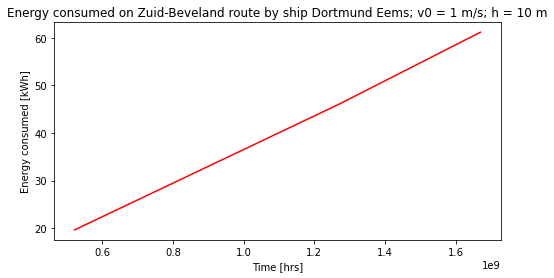

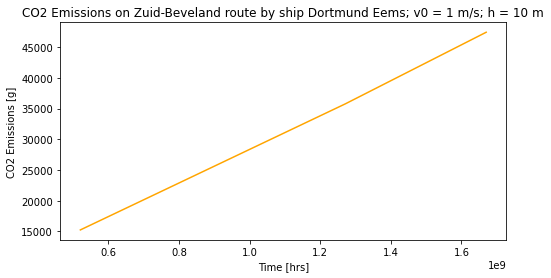

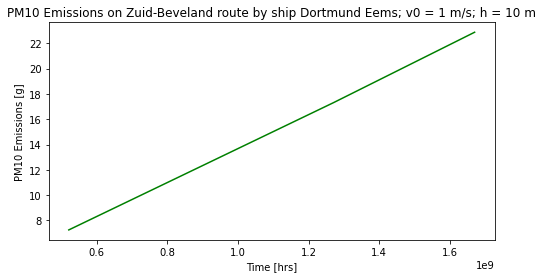

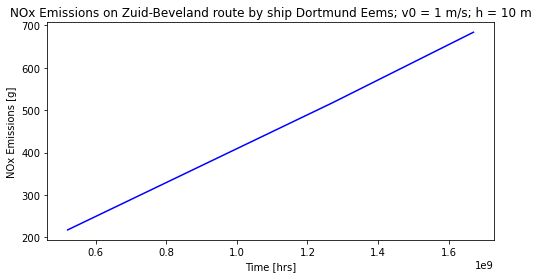

In [43]:
print(df.keys())
time = (df['time_stop'] - df['time_start']) / 3600
x = time.cumsum()
y1 = df['total_energy'].cumsum()
y2 = df['total_emission_CO2'].cumsum()
y3 = df['total_emission_PM10'].cumsum()
y4 = df['total_emission_NOX'].cumsum()

plt.figure(figsize=(8,4))
plt.plot(x,y1, color = 'red')
plt.xlabel('Time [hrs]')
plt.ylabel('Energy consumed [kWh]')
plt.title('Energy consumed on Zuid-Beveland route by ship Dortmund Eems; v0 = 1 m/s; h = 10 m')

plt.figure(figsize=(8,4))
plt.plot(x,y2, color = 'orange')
plt.xlabel('Time [hrs]')
plt.ylabel('CO2 Emissions [g]')
plt.title('CO2 Emissions on Zuid-Beveland route by ship Dortmund Eems; v0 = 1 m/s; h = 10 m')

plt.figure(figsize=(8,4))
plt.plot(x,y3, color = 'green')
plt.xlabel('Time [hrs]')
plt.ylabel('PM10 Emissions [g]')
plt.title('PM10 Emissions on Zuid-Beveland route by ship Dortmund Eems; v0 = 1 m/s; h = 10 m')

plt.figure(figsize=(8,4))
plt.plot(x,y4, color = 'blue')
plt.xlabel('Time [hrs]')
plt.ylabel('NOx Emissions [g]')
plt.title('NOx Emissions on Zuid-Beveland route by ship Dortmund Eems; v0 = 1 m/s; h = 10 m')

In [44]:
np.sum(df['total_energy'])

61.14545612816353

In [45]:
# plot route used for the energy calculation
plt.figure(figsize = (12,12))
energycalculation.plot()

<Figure size 864x864 with 0 Axes>

In [46]:
# Plot entire network
m = folium.Map(location=[51.7, 4.4], zoom_start = 10)

for edge in FG.edges(data = True):
    # print(edge)
    points_x = list(edge[2]["geometry"].coords.xy[0])
    points_y = list(edge[2]["geometry"].coords.xy[1])
    
    line = []
    for i, _ in enumerate(points_x):
        line.append((points_y[i], points_x[i]))
    
    if edge[2]["Name"] in ["Voorhavens Jachtensluis", "Voorhavens Volkeraksluizen"]:
        folium.PolyLine(line, color = "red", weight = 5, popup = edge[2]["Name"]).add_to(m)
    
    else:
        
        folium.PolyLine(line, weight = 2, popup = edge[2]["Name"]).add_to(m)

m

KeyError: 'geometry'

### 8. Visualise on Google Earth

In [ ]:
plot.vessel_kml(env, [vessel], fname='vessel_movements.kml')

### Sandbox

### Create locks (locks not implemented yet in this example)
We can see on the maps that there are locks on the graph, but that the information on the locks is limited. The following edges represent locks (NB: click the edges to show info:

- Voorhavens Jachtensluis
- Voorhavens Volkeraksluizen

These edges will be replaced by two lock elements. The Jachtensluizen are mainly designed for yachts and pleasure craft, and have a length of 135 meters and a width of 16 meters. The Volkeraksluizen have three chambers each with a length of 330 meters and a width of 24 meters. For now we'll assume that both locks have a maximum allowable draught of 4.5 meters.

Additional information on the locks can be found on the [Rijkswaterstand website (link in Dutch)](https://www.rijkswaterstaat.nl/water/waterbeheer/bescherming-tegen-het-water/waterkeringen/deltawerken/volkeraksluizen.aspx). 

### Show loginfo of the locks
The locking does not work yet in this example

In [ ]:
pd.DataFrame.from_dict(volkerak_lock_nr_1.log)

In [ ]:
pd.DataFrame.from_dict(volkerak_lock_nr_2.log)

In [ ]:
pd.DataFrame.from_dict(volkerak_lock_nr_3.log)